In [29]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
DATASET_DIR = './data/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1', 'domain1_score', 'essay_id'])
prompt_index = X['essay_set']
# X = X.drop(columns=['essay_set'])
prompts_text = open(os.path.join(DATASET_DIR, 'prompt.txt')).read().splitlines()
X.head()

,essay_set,essay
0,1,"Dear local newspaper, I think effects computer..."
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu..."
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,1,"Dear Local Newspaper, @CAPS1 I have found that..."
4,1,"Dear @LOCATION1, I know having computers has a..."


In [31]:
from collections import Counter
import re
from nltk.corpus import stopwords
import numpy as np

def tokenize(essays):
  """Tokenize essay into words, remove stopwords and lowercasing"""
  res = []
  for essay in essays:
    essay = re.sub(r'[^\w\s]', '', essay)  # Remove punctuation
    essay = essay.lower()  # Lowercase
    essay = essay.split()
    essay = [word for word in essay if word not in stopwords.words('english')]
    res.append(essay)
  return res
    
def compute_generic_rate(corpus):
    """Compute generic rates G_i from the entire corpus."""
    word_counts = Counter()
    total_words = 0
    for essay in corpus:
        word_counts.update(essay)
        total_words += len(essay)
    return {word: count / total_words for word, count in word_counts.items()}

def compute_prompt_specific_rate(prompt_corpus):
    """Compute prompt-specific rates S_i for a specific prompt."""
    word_counts = Counter()
    total_words = 0
    for essay in prompt_corpus:
      word_counts.update(essay)
      total_words += len(essay)
    
    return {word: count / total_words for word, count in word_counts.items()}

def compute_psi(essay, generic_rate, prompt_specific_rate):
    """Compute the Prompt-Specific Index for a single essay."""
    N = len(essay)  # Total number of words in the essay
    if N == 0:  # Avoid division by zero
        return 0

    psi_sum = 0
    for word in essay:
        G_i = generic_rate.get(word, 0)  # Default to 0 if word not in vocabulary
        S_i = prompt_specific_rate.get(word, 0)  # Default to 0 if word not in prompt
        psi_sum += np.sqrt(S_i * (1 - G_i))

    return psi_sum / N


In [32]:
# process all essays
# X_p = pd.DataFrame(tokenize(X['essay']))

In [33]:
X_p = np.array(pd.read_csv(os.path.join(SAVE_DIR, 'X_p.csv')))
tmp = []
for i in range(X_p.shape[0]):
  tmp.append(np.array([x for x in X_p[i] if not pd.isnull(x)]))
X_p = tmp

In [34]:
# save X_p cuz it takes 12mins to compute
# X_p_df = pd.DataFrame(X_p)
# X_p_df.to_csv(os.path.join(SAVE_DIR, 'X_p.csv'), index=False)

In [35]:
# generic_rate = compute_generic_rate(X_p)

# essay_prompt = 1
# indices = [i for i, index in enumerate(prompt_index) if index == essay_prompt]
# prompt_corpus =  [X_p[i] for i in indices]

# prompt_rate = compute_prompt_specific_rate(prompt_corpus)
# psi = compute_psi(X_p[-1], generic_rate, prompt_rate)
# print(psi)

In [44]:
# df = X_p.copy()
np.random.seed(0)
from sklearn.model_selection import train_test_split
# train valid split
X_train, X_valid, y_train, y_valid = train_test_split(X_p, X['essay_set'], test_size=0.2, random_state=0)
# split train into on and off topic
X_on, X_off, y_on, y_off= train_test_split(X_valid, y_valid, test_size=0.5, random_state=0)
# make y_off prompt different

# split y_valid to 2 parts, just y_valid
test = y_off
y_off= y_valid.apply(lambda x: (x+np.random.randint(1, 9))%9 + 1)
for i in range(len(test)):
  if(test.iloc[i] == y_off.iloc[i]):
    #change y off so it is different
    y_off.iloc[i] = (y_off.iloc[i] + 1) % 9 + 1

In [45]:
y_on, y_off = y_on.reset_index(drop=True), y_off.reset_index(drop=True)

In [37]:
generic_rate= compute_generic_rate(X_train)
# generic_rate_off= compute_generic_rate(X_off)

In [39]:
prompt_rates= []
for i in range(1, 9):
  indices = [j for j, index in enumerate(y_train) if index == i]
  prompt_corpus =  [X_train[j] for j in indices]
  prompt_rates.append(compute_prompt_specific_rate(prompt_corpus))

# prompt_rates_off = []
# for i in range(1, 9):
#   indices = [j for j, index in enumerate(test) if index == i]
#   prompt_corpus =  [X_off[j] for j in indices]
#   prompt_rates_off.append(compute_prompt_specific_rate(prompt_corpus))

In [ ]:

# compute psi for all essays
psi_on = []
i = 0
for essay in X_on:
  psi_on.append(compute_psi(essay, generic_rate, prompt_rates[y_on[i] - 1]))
  i += 1

psi_off = []
i = 0
for essay in X_off:
  psi_off.append(compute_psi(essay, generic_rate, prompt_rates[y_off[i] - 1]))



determining the threshold using roc 

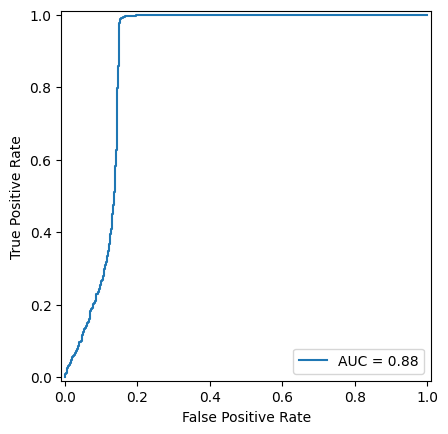

0.02993962423767886


In [55]:
# find threshold for psi 
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from matplotlib import pyplot as plt

# concat 2 arrays
pred_proba = np.array((psi_on, psi_off)).flatten()
true = np.array((np.ones(len(psi_on)).tolist(), np.zeros(len(psi_off)).tolist())).flatten()
fpr, tpr, threshold = roc_curve(true, pred_proba)
roc_auc = auc(fpr, tpr)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

# find threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(optimal_threshold)

In [57]:
# compute accuracy, confusion matrix
pred = np.array([1 if x > optimal_threshold else 0 for x in pred_proba])
accuracy = np.mean(pred == true)
print(accuracy)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true, pred)
print(cm)

0.9171802773497689
[[1096  202]
 [  13 1285]]


determine the threshold using the percentile value

In [60]:
threshold = np.percentile(psi_on, 5)
print(threshold)
# confusion matrix
pred = np.array([1 if x > threshold else 0 for x in pred_proba])
accuracy = np.mean(pred == true)
print(accuracy)

cm = confusion_matrix(true, pred)
print(cm)

0.036904935323123514
0.9006163328197226
[[1105  193]
 [  65 1233]]
